In [1]:
from scipy.signal import convolve2d
from scipy import misc
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.setrecursionlimit(1000000000)
%matplotlib inline

In [2]:
def gaussian_filter(kernel_size=(5,5), standard_deviation=1.4, normalize=True):
    res = np.zeros(shape=kernel_size)
    centerI = ( kernel_size[0] - 1 ) / 2
    centerJ = ( kernel_size[1] - 1 ) / 2
    for i in range(kernel_size[0]):
        for j in range(kernel_size[1]):
            res[i][j] = np.exp( -( (i - centerI)**2. + (j - centerJ)**2. ) / ( 2. * standard_deviation**2. )) \
                        / ( 2. * np.pi * standard_deviation**2. )
    
    if normalize:
        res /= np.sum(res)
    return res

def smooth_gaussian(input_image):
    return convolve2d(input_image, gaussian_filter(), mode='same')

In [3]:
class EdgeDetector(object):
    def __init__(self, smooth_image=None):
        self.smooth_image = smooth_image
    
    def detect_edges(self, input_image):
        raise NotImplementedError('Please implement this method')

In [4]:
class OperatorEdgeDetector(EdgeDetector):
    def __init__(self, filterX, filterY, smooth_image=smooth_gaussian):
        super().__init__(smooth_image=smooth_image)
        self.filterX = filterX
        self.filterY = filterY
        
    def get_gradients(self, input_image):
        gradX = convolve2d(input_image, self.filterX, mode='same')
        gradY = convolve2d(input_image, self.filterY, mode='same')
        return gradX, gradY
    
    def detect_edges(self, input_image):
        if self.smooth_image is not None:
            input_image = self.smooth_image(input_image)
        
        gradX, gradY = self.get_gradients(input_image)
        result = np.sqrt( np.power(gradX, 2) + np.power(gradY, 2) )
        return result

In [5]:
class SobelEdgeDetector(OperatorEdgeDetector):
    def __init__(self, smooth_image=smooth_gaussian):
        filterX = np.array([[-1, 0, 1],
                            [-2, 0, 2],
                            [-1, 0, 1]], dtype=np.float32)
        filterY = np.array([[-1, -2, -1],
                            [0, 0, 0],
                            [1, 2, 1]], dtype=np.float32)
        super().__init__(filterX=filterX, filterY=filterY, smooth_image=smooth_image)

In [6]:
class PrewittEdgeDetector(OperatorEdgeDetector):
    def __init__(self, smooth_image=smooth_gaussian):
        filterX = np.array([[-1, 0, 1],
                            [-1, 0, 1],
                            [-1, 0, 1]], dtype=np.float32)
        filterY = np.array([[-1, -1, -1],
                            [0, 0, 0],
                            [1, 1, 1]], dtype=np.float32)
        super().__init__(filterX=filterX, filterY=filterY, smooth_image=smooth_image)

In [7]:
class RobertsEdgeDetector(OperatorEdgeDetector):
    def __init__(self, smooth_image=smooth_gaussian):
        filterX = np.array([[-1, 0],
                            [0, 1]], dtype=np.float32)
        filterY = np.array([[0, -1],
                            [1, 0]], dtype=np.float32)
        super().__init__(filterX=filterX, filterY=filterY, smooth_image=smooth_image)

In [8]:
class CannyEdgeDetector(EdgeDetector):
    def __init__(self, 
                 smooth_image=smooth_gaussian, 
                 gradient_calculator=SobelEdgeDetector(), 
                 threshold_low=70, 
                 threshold_high=200):
        super().__init__(smooth_image)
        self.gradient_calculator = gradient_calculator
        self.threshold_low = threshold_low
        self.threshold_high = threshold_high



    def filter_necessary(self, i, j, result, used, gradient, angle):
        def is_largest(cur_i, cur_j, neighbours):
            def is_larger(cur_i, cur_j, item_i, item_j):
                if item_i < 0 or item_i >= len(gradient):         return True
                if item_j < 0 or item_j >= len(gradient[item_i]): return True
                return gradient[cur_i][cur_j] >= gradient[item_i][item_j]
            
            return all([ is_larger(cur_i, cur_j, item_i, item_j) for (item_i, item_j) in neighbours])

        
        def update_result(cur_i, cur_j, neighbours):
            if is_largest(cur_i, cur_j, neighbours):   result[i][j] = 255
            else:                                      result[i][j] = 0
        
        if i < 0 or i >= len(result):    return
        if j < 0 or j >= len(result[i]): return
        if used[i][j]:                   return
        used[i][j] = True
        
        if self.threshold_low <= result[i][j] <= self.threshold_high:
            if angle[i][j] == 0:          update_result(i, j, [(i, j-1), (i, j+1)])
            if angle[i][j] == np.pi/4:    update_result(i, j, [(i-1, j+1), (i+1, j-1)])
            if angle[i][j] == np.pi/2:    update_result(i, j, [(i-1, j), (i+1, j)])
            if angle[i][j] == np.pi*3/4:  update_result(i, j, [(i, j+1), (i+1, j+1)])
    
        if result[i][j] == 255:
            self.filter_necessary(i+1, j, result, used, gradient, angle)
            self.filter_necessary(i-1, j, result, used, gradient, angle)
            self.filter_necessary(i, j+1, result, used, gradient, angle)
            self.filter_necessary(i, j-1, result, used, gradient, angle)
        
    def detect_edges(self, input_image):
        if self.smooth_image is not None:
            input_image = self.smooth_image(input_image)
        
        gradX, gradY = self.gradient_calculator.get_gradients(input_image)
        gradient = np.sqrt( np.power(gradX, 2), np.power(gradY, 2) )
        result = np.copy(gradient)
        angle = np.arctan2(gradY, gradX)
        
        def normalize_angle(val):
            val = val if val > 0 else val + 2*np.pi
            val = min([np.pi*0/4, np.pi*1/4, np.pi*2/4, np.pi*3/4,
                                   np.pi*4/4, np.pi*5/4, np.pi*6/4, np.pi*7/4, 
                                   np.pi*8/4], key=lambda x: abs(x-val))
            if val == np.pi*2 or val == np.pi: val = 0
            if val > np.pi: val -= np.pi
            return val
        
        for i in range(len(angle)):
            for j in range(len(angle[i])):
                angle[i][j] = normalize_angle( angle[i][j] )
        
        idx = result[:,:] > self.threshold_high
        result[idx] = 255
        idx = result[:,:] < self.threshold_low
        result[idx] = 0
        
        used = np.zeros(shape=gradient.shape)
        for i in range(len(used)):
            for j in range(len(used[i])):
                if result[i][j] == 255:
                    self.filter_necessary(i, j, result, used, gradient, angle)
                    
        idx = result[:,:] != 255
        result[idx] = 0
        return result

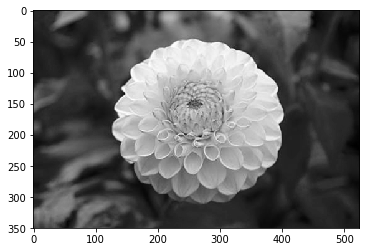

In [9]:
img = misc.imread('./test_image.jpg', mode='L')
plt.imshow(img, cmap='gray')

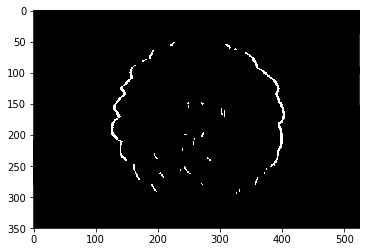

In [10]:
canny = CannyEdgeDetector(threshold_high=150, threshold_low=70)
out = canny.detect_edges(img)
plt.imshow(out, cmap='gray')

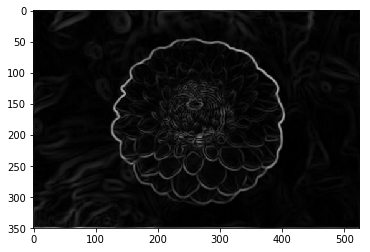

In [11]:
sobel = SobelEdgeDetector()
out = sobel.detect_edges(img)
plt.imshow(out, cmap='gray')

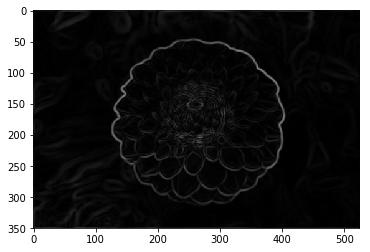

In [12]:
roberts = RobertsEdgeDetector()
out = roberts.detect_edges(img)
plt.imshow(out, cmap='gray')

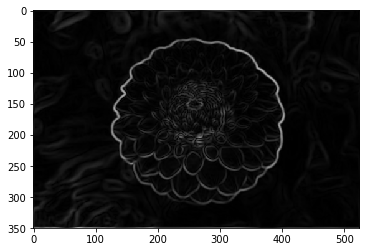

In [13]:
prewitt = PrewittEdgeDetector()
out = prewitt.detect_edges(img)
plt.imshow(out, cmap='gray')